In [28]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torch.nn.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Seed control, for better reproducibility 
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
    #generator.cuda()
    #discriminator.cuda()
    #adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    cudnn.benchmark=False
    Tensor = torch.FloatTensor

print(device)

EPOCHS = 1500


cuda:0


In [2]:
def imshow(img):
    # custom show in order to display
    # torch tensors as numpy
    npimg = img.numpy() / 2 + 0.5 # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch_size = 250 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

dataset = dset.CIFAR10(root='data/cifar/', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

# frogs are the sixth class in the dataset 
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

frog_index = 6
dog_index = 5

used_indexes = [
    frog_index,
    dog_index
]

subset_indexes = [i for i, x in enumerate(dataset.targets) if x in used_indexes]
print("number of frog or dog imgs: ", len(subset_indexes))

frog_dog_set = torch.utils.data.Subset(dataset, subset_indexes)


dataloader = torch.utils.data.DataLoader(frog_dog_set, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

Files already downloaded and verified
number of frog or dog imgs:  10000


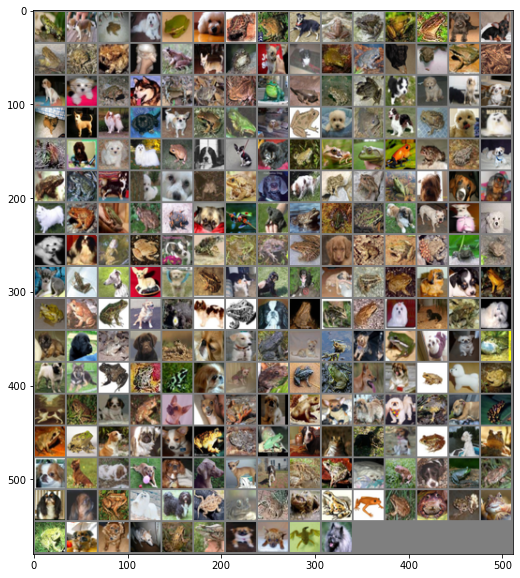

Image shape:  torch.Size([3, 32, 32])


In [3]:
# get some random training images
dataiter = iter(dataloader)
real_image_examples, classes = dataiter.next()
classes = classes - 5

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(real_image_examples, nrow=int(np.sqrt(batch_size))))
print("Image shape: ", real_image_examples[0].size())

In [4]:
latent_dim = 32
height = 32
width = 32
channels = 3
ohe_embedded_dim = 8
n_classes = 2

# Note: according to Radford (2016), is there anything done here
# that potentially could have been different? 
# Also: adda review of BatchNorm here. 

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        
        # Set up the ohe -> FC 256
        self.fc = nn.Sequential(
            nn.Linear(n_classes, ohe_embedded_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # First, transform the input into a 8x8 128-channels feature map
        self.init_size = width // 4 # one quarter the image size 
        self.l1 = nn.Sequential( nn.Linear(latent_dim + ohe_embedded_dim, 256 * self.init_size ** 2) )
        
        # Without ohe below
        #self.l1 = nn.Sequential( nn.Linear(latent_dim, 256 * self.init_size ** 2) )
        
        # there is no reshape layer, this will be done in forward function
        # alternately we could us only the functional API
        # and bypass sequential altogether

        # we will use the sequential API
        # in order to create some blocks
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2, mode='bilinear'), #16x16
            nn.Conv2d(256, 256, 3, padding=1), #16x16

            # Then, add a convolution layer
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample to 32x32
            nn.Upsample(scale_factor=2, mode='bilinear'), # 32x32
            nn.ConvTranspose2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Produce a 32x32xRGB-channel feature map
            nn.Conv2d(32, channels, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, ohe):
        out_ohe = self.fc(ohe)
        
        # expand the sampled z to 8x8
        z = torch.cat((z, out_ohe), dim=1)
        
        out = self.l1(z)
        
        out = torch.reshape(out, (out.shape[0], 256, self.init_size, self.init_size))
        
        
        
        # use the view function to reshape the layer output
        #  old way for earlier Torch versions: out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [12]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(n_classes, 16),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential( #input 32x32
            nn.Conv2d(3, 16, 3, stride=2, padding=1), #16x16
            nn.LeakyReLU(0.2, inplace=True),
            # dropout layer - important trick!
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 16x16
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),

            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 8x8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),

            nn.Conv2d(64, 128, 3, stride=2, padding=1), #4x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),

            nn.Conv2d(128, 128, 3, stride=1, padding=1), #4x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # 4x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(256, 0.8),

            nn.Conv2d(256, 256, 3, stride=1, padding=1), # 4x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(256, 0.8),
        )

        # The height and width of downsampled image
        ds_size = width // 2 ** 4
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(256 * ds_size ** 2 + 16, 1), 
                                                  nn.Sigmoid())

    def forward(self, img, ohe):
        out_ohe = self.fc(ohe)
        
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        
        # concat ohe output
        out = torch.cat((out, out_ohe), dim=1)
        
        validity = self.classification_layer(out)
        return validity

In [13]:
# custom weights initialization called on netG and netD
# this function from PyTorch's officail DCGAN example:
# https://github.com/pytorch/examples/blob/master/dcgan/main.py#L112
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # filters are zero mean, small STDev
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # batch norm is unit mean, small STDev
        m.bias.data.fill_(0) # like normal, biases start at zero

## Least Squares GAN

In [86]:
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)


# LSGAN says they use ADAM, but follow up papers say RMSProp is lsightly better
#lr = 0.0002
#betas = (0.5, 0.999)

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(),
                                              momentum=0.0004,
                                              lr=0.0008, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(),
                                    lr=0.0004, weight_decay=1e-8)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.3, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): D

In [87]:
iterations = EPOCHS #defined above
iterations = 1000

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
fixed_random_ohe = Tensor(np.eye(n_classes)[np.random.choice(n_classes, plot_num_examples)]).to(device)
img_list = []
total_steps = 0

real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:], padding=2, normalize=False, nrow=5),(0,1,2))


In [ ]:
%%time
log_every = 10
n_classes = 2


# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# Becasue not much is changing, an interesting update would
# be to write a "train step" function and use it here.
# Something like: train_step(g, d, imgs, loss_select=MSE, num_d_steps=1)

for step in range(iterations):
    total_steps = total_steps+1

    for i, (imgs, classes) in enumerate(dataloader):
        
        # Get the OHE of the imgs we used.
        classes = classes - 5
        ohe = F.one_hot(classes, num_classes=2).to(device)
        ohe = ohe.float()

        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()
        
        random_ohe = Variable(Tensor(np.eye(n_classes)[np.random.choice(n_classes, imgs.shape[0])]))

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors, random_ohe)

        # Assemble labels that say "all real images"
        # misleading target, c=1
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

        # Get MSE Loss function
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images, random_ohe), misleading_targets)

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()
        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        combined_images = torch.cat([real_images, generated_images.detach()])
        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        # real label, a=1 and fake label, b=0
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape).to(device)

        # Setup Discriminator loss
        # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size], ohe), labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:], random_ohe), labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % log_every == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors, fixed_random_ohe).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        # in addition, save off a checkpoint of the current models and images
        ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
        np.save('models/gan_models/ls_images.npy',ims)

        # save the state of the models (will need to recreate upon reloading)
        torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
        torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')
        

Loss at step 1: D(z_c)=0.2493262141942978, D(G(z_mis))=0.223983496427536
Loss at step 11: D(z_c)=0.28626132011413574, D(G(z_mis))=0.14608915150165558
Loss at step 21: D(z_c)=0.22426359355449677, D(G(z_mis))=0.4399096369743347
Loss at step 31: D(z_c)=0.16476203501224518, D(G(z_mis))=0.45486781001091003
Loss at step 41: D(z_c)=0.19200289249420166, D(G(z_mis))=0.46001484990119934
Loss at step 51: D(z_c)=0.29858022928237915, D(G(z_mis))=0.0450846292078495
Loss at step 61: D(z_c)=0.10412655770778656, D(G(z_mis))=0.41718170046806335
Loss at step 71: D(z_c)=0.026679549366235733, D(G(z_mis))=0.5123159885406494
Loss at step 81: D(z_c)=0.14344316720962524, D(G(z_mis))=0.369682639837265
Loss at step 91: D(z_c)=0.19038856029510498, D(G(z_mis))=0.13622555136680603
Loss at step 101: D(z_c)=0.24881494045257568, D(G(z_mis))=0.08353055268526077
Loss at step 111: D(z_c)=0.03642416000366211, D(G(z_mis))=0.4435786008834839
Loss at step 121: D(z_c)=0.18438498675823212, D(G(z_mis))=0.6561118364334106
Loss a

In [ ]:
def norm_grid(im):
    # first half should be normalized and second half also, separately
    im = im.astype(np.float)
    rows,cols,chan = im.shape
    cols_over2 = int(cols/2)
    tmp = im[:,:cols_over2,:]
    im[:,:cols_over2,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    tmp = im[:,cols_over2:,:]
    im[:,cols_over2:,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    return im


fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [72]:
%%time
log_every = 10
n_classes = 2


# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# Becasue not much is changing, an interesting update would
# be to write a "train step" function and use it here.
# Something like: train_step(g, d, imgs, loss_select=MSE, num_d_steps=1)

for step in range(iterations*2):
    total_steps = total_steps+1

    for i, (imgs, classes) in enumerate(dataloader):
        
        # Get the OHE of the imgs we used.
        classes = classes - 5
        ohe = F.one_hot(classes, num_classes=2).to(device)
        ohe = ohe.float()

        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()
        
        random_ohe = Variable(Tensor(np.eye(n_classes)[np.random.choice(n_classes, imgs.shape[0])]))

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors, random_ohe)

        # Assemble labels that say "all real images"
        # misleading target, c=1
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

        # Get MSE Loss function
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images, random_ohe), misleading_targets)

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()
        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        combined_images = torch.cat([real_images, generated_images.detach()])
        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        # real label, a=1 and fake label, b=0
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape).to(device)

        # Setup Discriminator loss
        # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size], ohe), labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:], random_ohe), labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % log_every == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors, fixed_random_ohe).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        # in addition, save off a checkpoint of the current models and images
        ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
        np.save('models/gan_models/ls_images.npy',ims)

        # save the state of the models (will need to recreate upon reloading)
        torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
        torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')
        

Loss at step 4: D(z_c)=0.08199410885572433, D(G(z_mis))=0.9748053550720215


KeyboardInterrupt: 

In [ ]:
def norm_grid(im):
    # first half should be normalized and second half also, separately
    im = im.astype(np.float)
    rows,cols,chan = im.shape
    cols_over2 = int(cols/2)
    tmp = im[:,:cols_over2,:]
    im[:,:cols_over2,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    tmp = im[:,cols_over2:,:]
    im[:,cols_over2:,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    return im


fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())